## **Conformal Prediction using Energy Hospital Load**

One example of the NP data is the electricity consumption of a hospital in SF. It has hourly reservation for the entire year of 2015.

### Extract Data and Split Data into Train, Val, Cal, and Test


**Extract Data From GitHub**

In [1]:
import numpy as np
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level, set_random_seed

In [2]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
file = 'energy/SF_hospital_load.csv'
# file = 'wp_log_peyton_manning.csv'

In [3]:
data_df = pd.read_csv(data_location + file)

In [4]:
data_df.head(5)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338
3,2015-01-01 04:00:00,778.737196
4,2015-01-01 05:00:00,787.835835


In [5]:
data_df.tail(5)

,ds,y
8755,2015-12-31 20:00:00,845.563081
8756,2015-12-31 21:00:00,827.530521
8757,2015-12-31 22:00:00,829.256300
8758,2015-12-31 23:00:00,813.937205
8759,2016-01-01 00:00:00,815.588584


**Split data into train, val, cal, and test in that order**

Do we need to instantiate a NP model `m` in order to split the df into train and test? If so, does the NP params make any diff to the outcome of this split? I'm presuming no atm.

In [6]:
m = NeuralProphet()
train_df, test_df = m.split_df(data_df, freq='H', valid_p = 1.0/16)
train_df, cal_df = m.split_df(train_df, freq='H', valid_p = 1.0/11)
train_df, val_df = m.split_df(train_df, freq='H', valid_p = 1.0/10)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.989% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.988% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.987% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils.return_df_in_

{'self': <neuralprophet.forecaster.NeuralProphet object at 0x7f1bca8290d0>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 0, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 'auto', 'daily_seasonality': 'auto', 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': None, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': None, 'quantiles': None, 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}


In [7]:
train_df.shape, val_df.shape, cal_df.shape, test_df.shape

((6721, 2), (746, 2), (746, 2), (547, 2))

In [8]:
# Training set start and end dates
train_df['ds'].min(), train_df['ds'].max()

(Timestamp('2015-01-01 01:00:00'), Timestamp('2015-10-08 01:00:00'))

In [9]:
# Validation set start and end dates
val_df['ds'].min(), val_df['ds'].max()

(Timestamp('2015-10-08 02:00:00'), Timestamp('2015-11-08 03:00:00'))

In [10]:
# Calibration set start and end dates
cal_df['ds'].min(), cal_df['ds'].max()

(Timestamp('2015-11-08 04:00:00'), Timestamp('2015-12-09 05:00:00'))

In [11]:
# Test set start and end dates
test_df['ds'].min(), test_df['ds'].max()

(Timestamp('2015-12-09 06:00:00'), Timestamp('2016-01-01 00:00:00'))

**Plot train_df**

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [13]:
x_size = 20
y_size = 8
figsize = (x_size, y_size)

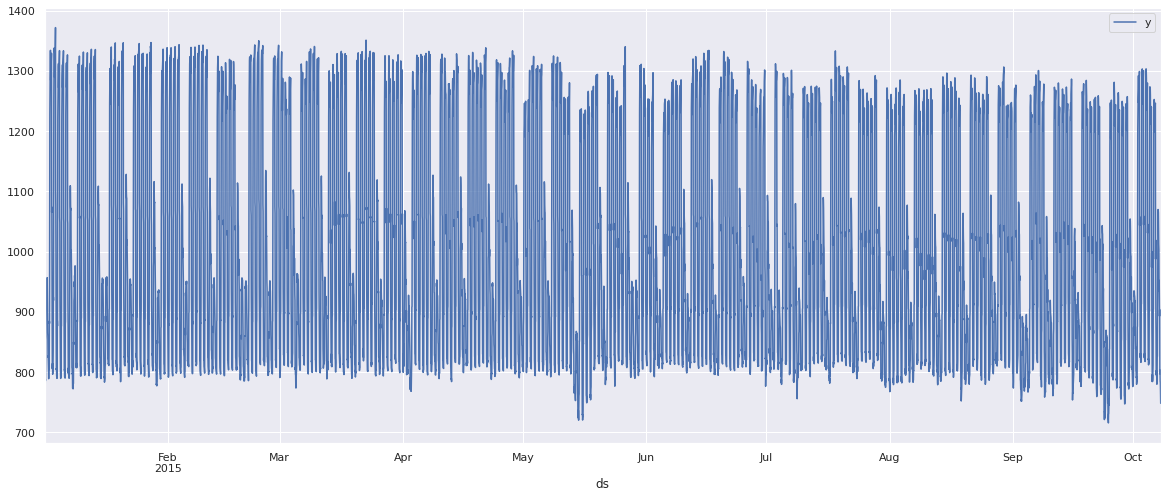

In [14]:
train_df.set_index('ds').plot(figsize=figsize);

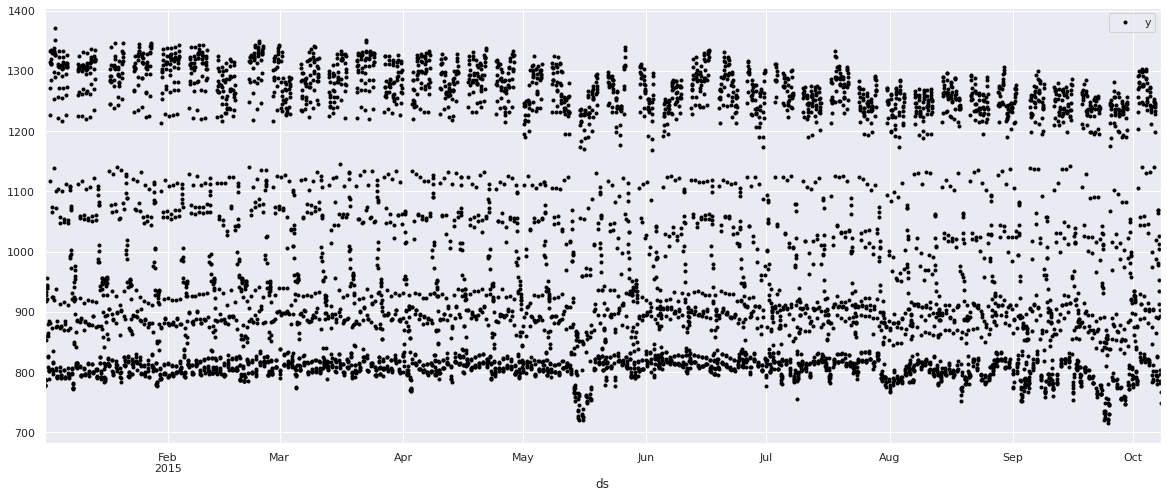

In [15]:
train_df.set_index('ds').plot(marker='.', linestyle='none', colormap='gray', figsize=figsize);

### Train the NP Models (with 5th/95th Quantiles)
- `m1`: Generic forecast of time-based features (like Facebook Prophet)
- `m2`: NP with 1-layer AR
- `m3`: NP with 4-layer deep AR

In [16]:
quantile_lo, quantile_hi = 0.05, 0.95
quantiles = [quantile_lo, quantile_hi]

In [17]:
m1 = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.01,
    quantiles=quantiles,
)
m2 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_reg=1,
    learning_rate = 0.01,
    quantiles=quantiles,
)
m3 = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=32,
    learning_rate=0.003,
    quantiles=quantiles,
)

INFO - (NP.config.__post_init__) - Note: Trend changepoint regularization is experimental.


{'self': <neuralprophet.forecaster.NeuralProphet object at 0x7f1bb18779d0>, 'growth': 'linear', 'changepoints': None, 'n_changepoints': 10, 'changepoints_range': 0.9, 'trend_reg': 1, 'trend_reg_threshold': False, 'yearly_seasonality': 'auto', 'weekly_seasonality': 6, 'daily_seasonality': 10, 'seasonality_mode': 'additive', 'seasonality_reg': 0, 'n_forecasts': 1, 'n_lags': 0, 'num_hidden_layers': 0, 'd_hidden': None, 'ar_reg': None, 'learning_rate': 0.01, 'epochs': None, 'batch_size': None, 'loss_func': 'Huber', 'optimizer': 'AdamW', 'newer_samples_weight': 2, 'newer_samples_start': 0.0, 'uncertainty_method': 'auto', 'prediction_interval': None, 'quantiles': [0.05, 0.95], 'impute_missing': True, 'impute_linear': 10, 'impute_rolling': 10, 'drop_missing': False, 'collect_metrics': True, 'normalize': 'auto', 'global_normalization': False, 'global_time_normalization': True, 'unknown_data_normalization': False}
{'self': <neuralprophet.forecaster.NeuralProphet object at 0x7f1bb1877b20>, 'grow

In [18]:
%%time
random_seed = 0
set_random_seed(random_seed)
metrics1 = m1.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics2 = m2.fit(train_df, freq='H', validation_df=val_df)
set_random_seed(random_seed)
metrics3 = m3.fit(train_df, freq='H', validation_df=val_df)
# metrics3 = m3.fit(train_df, freq='H', validation_df=val_df, progress='plot')

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 114
  0%|          | 0/114 [00:00<?, ?it/s]WARNING - (py.warnings._showwarnmsg) - /home/kevin/anaconda3/envs/dev/lib/python3.9/site-packages/torch/nn/modules/loss.py:921: UserWarning: Using a target size (torch.Size([746])) that is different to the input size (torch.Size([746, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduct

CPU times: user 6min 12s, sys: 384 ms, total: 6min 12s
Wall time: 2min 44s


In [19]:
metrics1.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.005676,44.631943,61.431704,0.01012,0.004564,0.107314,223.560593,276.480316


In [20]:
metrics2.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.001826,23.78648,35.067682,0.003231,0.001203,0.10699,218.762833,276.046082


In [21]:
metrics3.tail(1)

,SmoothL1Loss,MAE,RMSE,Loss,RegLoss,SmoothL1Loss_val,MAE_val,RMSE_val
113,0.000155,7.240371,10.177473,0.000155,0.0,0.108465,219.429321,277.942871


### Conformalize and plot

In [22]:
alpha = 0.1

**Naive**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


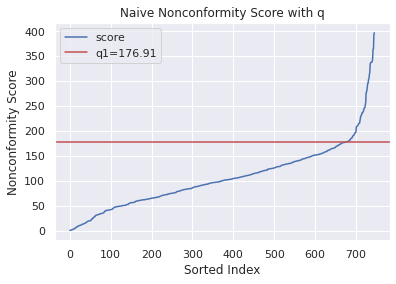

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


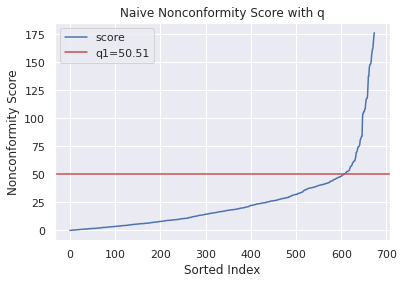

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


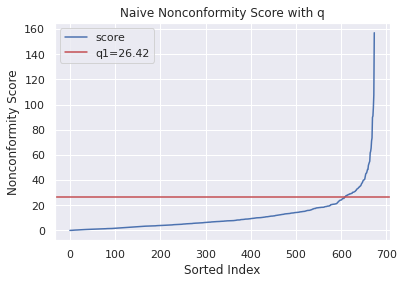

In [23]:
method='naive'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)

In [24]:
m1.q, m2.q, m3.q

(176.90842283828124, 50.513631634374974, 26.418522632812483)

In [25]:
forecast1 = m1.predict(train_df)
forecast2 = m2.predict(train_df)
forecast3 = m3.predict(train_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO

In [26]:
# method='naive'
# forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [27]:
forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1-q,yhat1+q
0,2015-01-01 01:00:00,778.007969,-16.373265,761.634705,670.388306,797.204346,1027.164795,-61.001808,-204.528198,584.726282,938.543127
1,2015-01-01 02:00:00,776.241750,-34.243703,741.998047,661.741577,783.580994,1027.152100,-73.693291,-211.460770,565.089624,918.906470
2,2015-01-01 03:00:00,779.357338,-41.711769,737.645569,632.641479,791.908447,1027.139648,-89.629135,-199.864868,560.737146,914.553992
3,2015-01-01 04:00:00,778.737196,-19.270155,759.467041,657.991394,805.841309,1027.126953,-108.229828,-159.430115,582.558618,936.375464
4,2015-01-01 05:00:00,787.835835,-20.579670,767.256165,667.945618,809.273010,1027.114502,-128.775284,-131.082977,590.347742,944.164587
...,...,...,...,...,...,...,...,...,...,...,...
6716,2015-10-07 21:00:00,803.247763,-36.092795,767.154968,690.925293,833.124146,971.390442,-48.206627,-156.028824,590.246545,944.063391
6717,2015-10-07 22:00:00,784.595778,-43.774000,740.821777,658.248413,787.226624,971.355713,-45.623661,-184.910339,563.913355,917.730200
6718,2015-10-07 23:00:00,782.117337,-57.990628,724.126709,646.537964,779.721008,971.321045,-46.828987,-200.365326,547.218286,901.035132
6719,2015-10-08 00:00:00,767.070346,-52.795993,714.274353,646.802979,744.957153,971.286377,-51.969368,-205.042679,537.365930,891.182776


In [28]:
forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1-q,yhat1+q
0,2015-01-01 01:00:00,778.007969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 02:00:00,776.241750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 03:00:00,779.357338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 04:00:00,778.737196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 05:00:00,787.835835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6716,2015-10-07 21:00:00,803.247763,-27.914817,775.332947,734.789795,818.699036,26.950663,748.382263,724.819315,825.846578
6717,2015-10-07 22:00:00,784.595778,-29.325758,755.27002,714.727234,798.635803,6.887729,748.382263,704.756388,805.783651
6718,2015-10-07 23:00:00,782.117337,15.563022,797.680359,757.137756,841.046204,49.298058,748.382263,747.166727,848.193991
6719,2015-10-08 00:00:00,767.070346,28.570401,795.640747,755.098145,839.007019,47.25848,748.382263,745.127115,846.154379


In [29]:
forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1-q,yhat1+q
0,2015-01-01 01:00:00,778.007969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 02:00:00,776.241750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 03:00:00,779.357338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 04:00:00,778.737196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 05:00:00,787.835835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6716,2015-10-07 21:00:00,803.247763,4.5496,807.797363,800.528809,816.31842,-143.314499,951.111877,781.378841,834.215886
6717,2015-10-07 22:00:00,784.595778,11.18236,795.778137,788.568176,803.452698,-155.333755,951.111877,769.359615,822.19666
6718,2015-10-07 23:00:00,782.117337,7.748508,789.865845,781.311035,795.42572,-161.246033,951.111877,763.447322,816.284367
6719,2015-10-08 00:00:00,767.070346,7.114225,774.18457,768.688843,782.289185,-176.927338,951.111877,747.766048,800.603093


In [30]:
cutoff = 7*24 # 0
x_size = 12
y_size = 6
figsize = (x_size, y_size)
plotting_backend = 'default'

WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


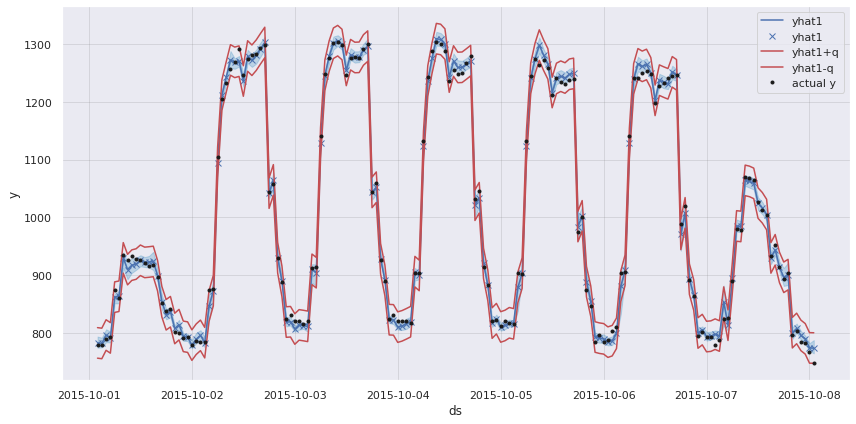

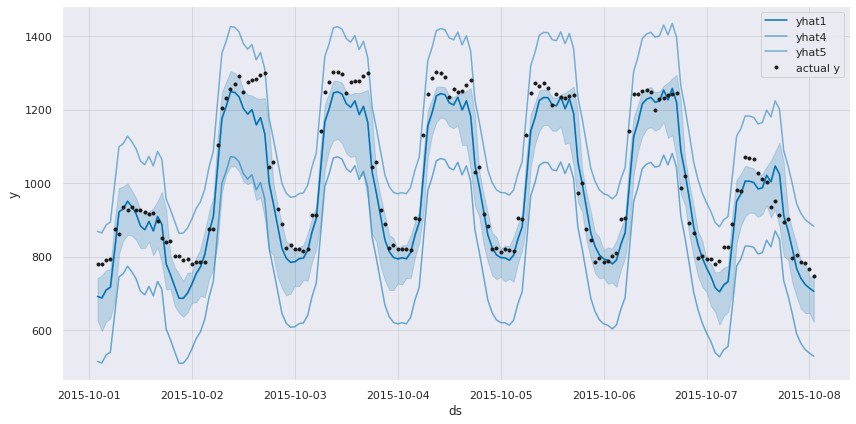

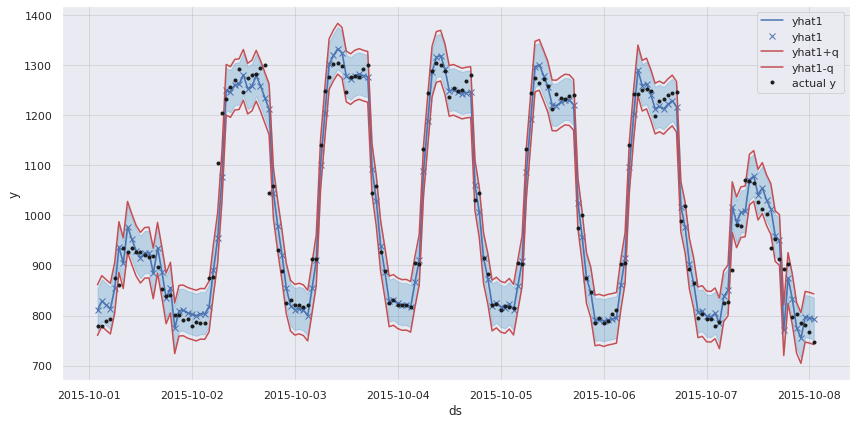

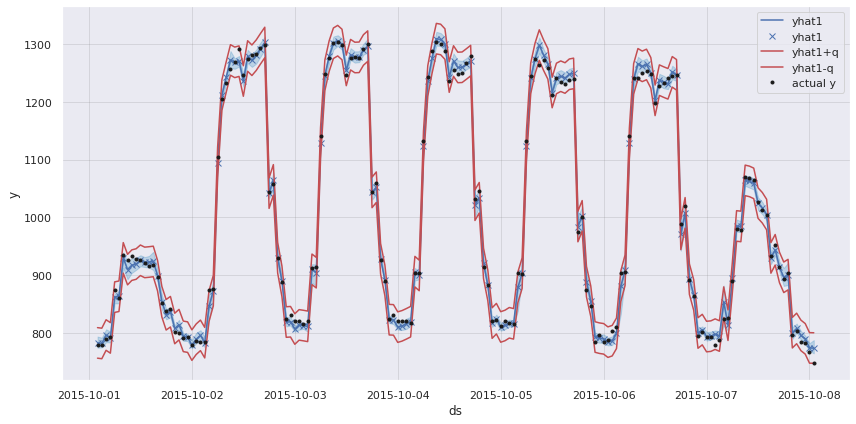

In [31]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)

m1.plot(forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m2.plot(forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m3.plot(forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)

**CQR**

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


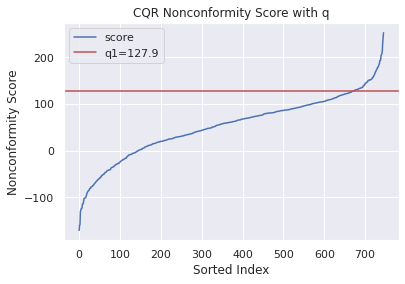

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


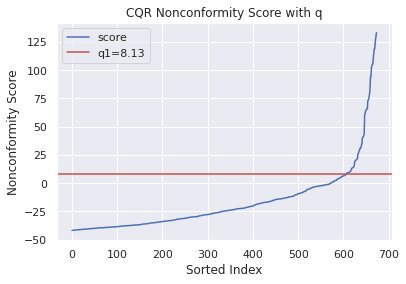

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.866% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


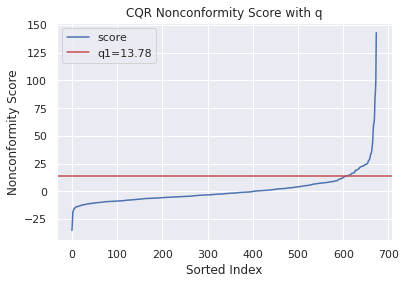

In [32]:
method='cqr'
m1.conformalize(cal_df, alpha=alpha, method=method)
m2.conformalize(cal_df, alpha=alpha, method=method)
m3.conformalize(cal_df, alpha=alpha, method=method)

In [33]:
m1.q, m2.q, m3.q

(127.89549846953128, 8.132101773437398, 13.77526935703122)

In [34]:
forecast1 = m1.predict(train_df)
forecast2 = m2.predict(train_df)
forecast3 = m3.predict(train_df)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.985% of the data.
INFO

In [35]:
# method='cqr'
# forecast1 = m1.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# forecast2 = m2.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)
# forecast3 = m3.conformalize_predict(test_df, df_cal=cal_df, alpha=alpha, method=method)

In [36]:
forecast1

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,trend,season_weekly,season_daily,yhat1 95.0%-q,yhat1 95.0%+q,yhat1 5.0%-q,yhat1 5.0%+q
0,2015-01-01 01:00:00,778.007969,-16.373265,761.634705,670.388306,797.204346,1027.164795,-61.001808,-204.528198,669.308847,925.099844,542.492807,798.283804
1,2015-01-01 02:00:00,776.241750,-34.243703,741.998047,661.741577,783.580994,1027.152100,-73.693291,-211.460770,655.685495,911.476492,533.846079,789.637076
2,2015-01-01 03:00:00,779.357338,-41.711769,737.645569,632.641479,791.908447,1027.139648,-89.629135,-199.864868,664.012949,919.803946,504.745981,760.536978
3,2015-01-01 04:00:00,778.737196,-19.270155,759.467041,657.991394,805.841309,1027.126953,-108.229828,-159.430115,677.945810,933.736807,530.095896,785.886893
4,2015-01-01 05:00:00,787.835835,-20.579670,767.256165,667.945618,809.273010,1027.114502,-128.775284,-131.082977,681.377512,937.168509,540.050119,795.841116
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6716,2015-10-07 21:00:00,803.247763,-36.092795,767.154968,690.925293,833.124146,971.390442,-48.206627,-156.028824,705.228647,961.019644,563.029794,818.820791
6717,2015-10-07 22:00:00,784.595778,-43.774000,740.821777,658.248413,787.226624,971.355713,-45.623661,-184.910339,659.331125,915.122122,530.352915,786.143912
6718,2015-10-07 23:00:00,782.117337,-57.990628,724.126709,646.537964,779.721008,971.321045,-46.828987,-200.365326,651.825510,907.616507,518.642465,774.433462
6719,2015-10-08 00:00:00,767.070346,-52.795993,714.274353,646.802979,744.957153,971.286377,-51.969368,-205.042679,617.061655,872.852652,518.907480,774.698477


In [37]:
forecast2

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0%-q,yhat1 95.0%+q,yhat1 5.0%-q,yhat1 5.0%+q
0,2015-01-01 01:00:00,778.007969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 02:00:00,776.241750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 03:00:00,779.357338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 04:00:00,778.737196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 05:00:00,787.835835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6716,2015-10-07 21:00:00,803.247763,-27.914817,775.332947,734.789795,818.699036,26.950663,748.382263,810.566934,826.831137,726.657693,742.921897
6717,2015-10-07 22:00:00,784.595778,-29.325758,755.27002,714.727234,798.635803,6.887729,748.382263,790.503701,806.767905,706.595132,722.859336
6718,2015-10-07 23:00:00,782.117337,15.563022,797.680359,757.137756,841.046204,49.298058,748.382263,832.914102,849.178305,749.005655,765.269858
6719,2015-10-08 00:00:00,767.070346,28.570401,795.640747,755.098145,839.007019,47.25848,748.382263,830.874917,847.139121,746.966043,763.230246


In [38]:
forecast3

,ds,y,residual1,yhat1,yhat1 5.0%,yhat1 95.0%,ar1,trend,yhat1 95.0%-q,yhat1 95.0%+q,yhat1 5.0%-q,yhat1 5.0%+q
0,2015-01-01 01:00:00,778.007969,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 02:00:00,776.241750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01 03:00:00,779.357338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01 04:00:00,778.737196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01 05:00:00,787.835835,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6716,2015-10-07 21:00:00,803.247763,4.5496,807.797363,800.528809,816.31842,-143.314499,951.111877,802.543151,830.09369,786.753539,814.304078
6717,2015-10-07 22:00:00,784.595778,11.18236,795.778137,788.568176,803.452698,-155.333755,951.111877,789.677428,817.227967,774.792907,802.343446
6718,2015-10-07 23:00:00,782.117337,7.748508,789.865845,781.311035,795.42572,-161.246033,951.111877,781.650451,809.20099,767.535766,795.086305
6719,2015-10-08 00:00:00,767.070346,7.114225,774.18457,768.688843,782.289185,-176.927338,951.111877,768.513915,796.064454,754.913573,782.464112


WARNING - (NP.forecaster.plot) - highlight_forecast_step_n is ignored since auto-regression not enabled.


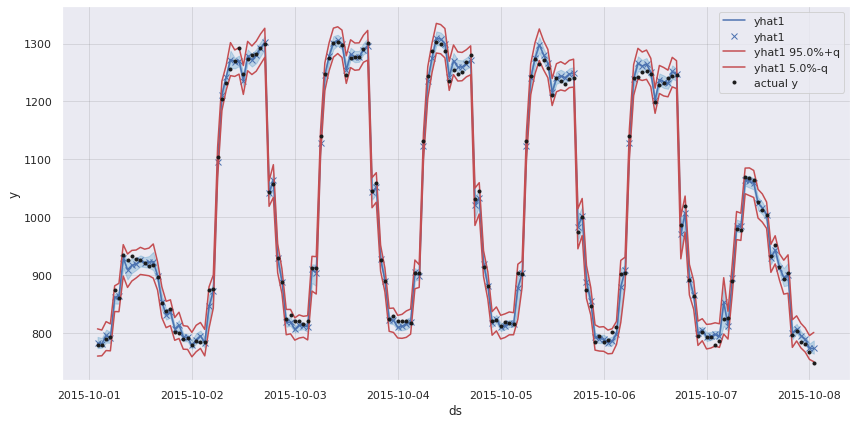

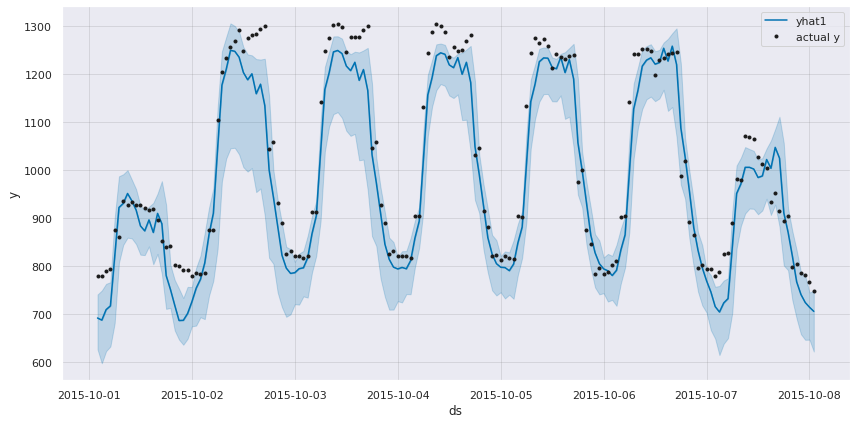

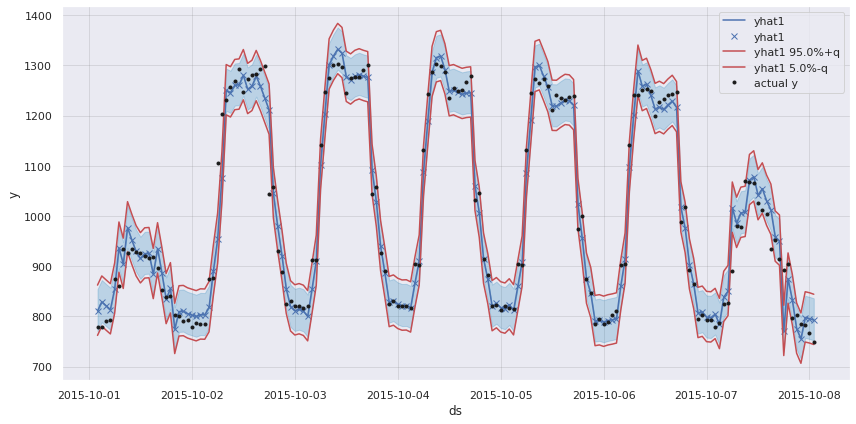

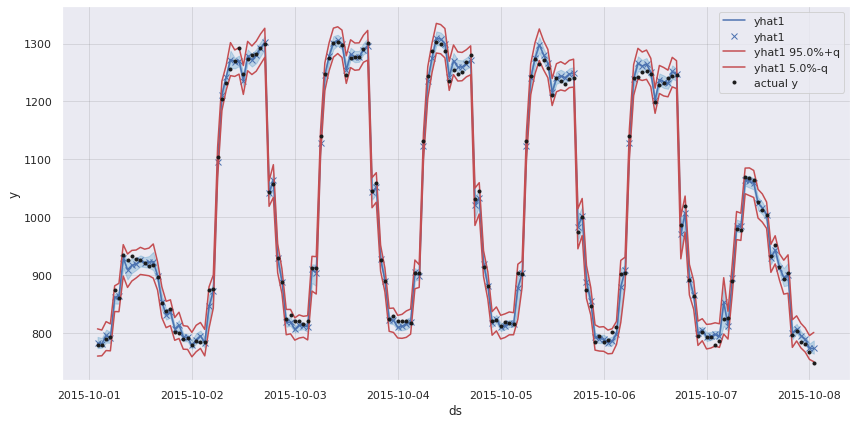

In [39]:
m1 = m1.highlight_nth_step_ahead_of_each_forecast(1)
m2 = m2.highlight_nth_step_ahead_of_each_forecast(1)
m3 = m3.highlight_nth_step_ahead_of_each_forecast(1)

m1.plot(forecast1[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m2.plot(forecast2[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)
m3.plot(forecast3[-cutoff:], figsize=figsize, plotting_backend=plotting_backend)